This notebook runs a defined pipeline on HCP subjects, on the Cedars-Sinai cluster.
After it is done preprocessing all subjects, it runs the leave-one-out IQ prediction a la Finn.

# Load libraries & helper functions

In [1]:
from helpers import *
%matplotlib inline

# Declare parameters

In [2]:
config.DATADIR                 = '/scratch/duboisjx/data/HCP/MRI'
# fMRI runs
session                        = 'REST2'
fmriRuns                       = ['rfMRI_'+session+'_LR','rfMRI_'+session+'_RL']
# use volume or surface data
config.fmriFileTemplate        = '#fMRIrun#.nii.gz'
#config.fmriFileTemplate        = '#fMRIrun#_Atlas.dtseries.nii'
#config.fmriFileTemplate        = '#fMRIrun#_Atlas_MSMAll.dtseries.nii'
config.overwrite               = False
config.pipelineName            = 'Finn'
config.Operations              = config.operationDict[config.pipelineName]
config.melodicFolder           = op.join('#fMRIrun#_hp2000.ica','filtered_func_data.ica') #the code #fMRIrun# will be replaced
config.movementRelativeRMSFile = 'Movement_RelativeRMS.txt'
config.movementRegressorsFile  = 'Movement_Regressors_dt.txt'
# parcellation for FC matrix
config.parcellationName        = 'shen2013'
config.parcellationFile        = '/scratch/duboisjx/data/parcellations/shenetal_neuroimage2013_new/shen_2mm_268_parcellation.nii.gz'
config.nParcels                = 268
config.maskParcelswithAll      = True
config.maskParcelswithGM       = False
# subject selection parameters
config.behavFile               = '/scratch/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_6_7_2017_0_44_41.csv'
config.release                 = 'all'
config.outScore                = 'PMAT24_A_CR'
# submit jobs with sge
config.queue        = True

# do not alter the following lines
if config.maskParcelswithGM:
    config.parcellationName = config.parcellationName + '_GM'
tmp = config.fmriFileTemplate.split('.')
if tmp[1]=='nii':
    config.isCifti = False
elif tmp[1]=='dtseries':
    config.isCifti = True
else:
    print 'unknown file extension'

if config.pipelineName is 'SiegelB':
    config.useFIX              = True
else:
    config.useFIX              = False
config.preWhitening            = False

# whether to use memmapping (which involves unzipping)
# deprecated
config.useMemMap               = False


# Subject selection

Selected 957 from the release all
Number of males is: 452
Age range is 22 - Age range is 22 - 36+
102008 : too much motion, exclude
103515 : too much motion, exclude
104820 : too much motion, exclude
107725 : too much motion, exclude
108121 : too much motion, exclude
114924 : too much motion, exclude
116524 : too much motion, exclude
123420 : too much motion, exclude
123723 : too much motion, exclude
124220 : too much motion, exclude
124624 : too much motion, exclude
130518 : too much motion, exclude
136732 : too much motion, exclude
139435 : too much motion, exclude
140824 : too much motion, exclude
141119 : too much motion, exclude
147030 : too much motion, exclude
151324 : too much motion, exclude
151526 : too much motion, exclude
151728 : too much motion, exclude
153833 : too much motion, exclude
154330 : too much motion, exclude
156233 : too much motion, exclude
156637 : too much motion, exclude
160830 : too much motion, exclude
161327 : too much motion, exclude
161832 : too much 

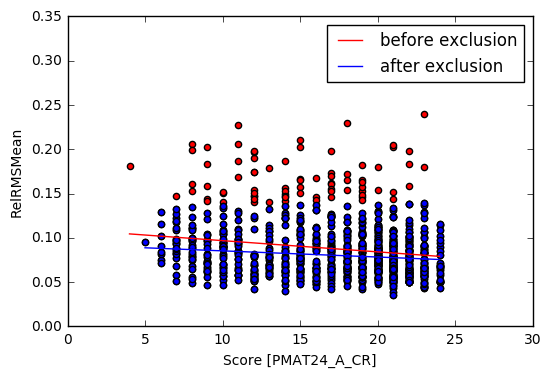

With all subjects: corr(IQ,motion) = -0.175 (p = 0.000)
After discarding high movers: corr(IQ,motion) = -0.149 (p = 0.000)
Keeping 876 subjects [414 M]


In [3]:
df = pd.read_csv(config.behavFile)
# select subjects according to release
if config.release == 'Q2':
    ind = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    ind = (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'Q2+S500':
    ind = (df['Release'] == 'Q2') | (df['Release'] == 'Q1') | (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'S900':
    ind = (df['Release'] == 'S900')
elif config.release == 'S1200':
    ind = (df['Release'] == 'S1200')
elif config.release == 'all':
    ind = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200'))
else:
    sys.exit("Invalid release code")
# select subjects that have completed all fMRI
ind = ind & ((df['fMRI_WM_PctCompl']==100) & (df['fMRI_Mot_PctCompl']==100) 
             & (df['fMRI_Lang_PctCompl']==100) & (df['fMRI_Emo_PctCompl']==100)         
             & (df['3T_RS-fMRI_PctCompl']==100) & (df['PMAT_Compl']==True))
df = df[ind]  
# check if either of the two subjects recommended for exclusion by HCP are still present
df = df[~df['Subject'].isin(['209733','528446'])]
df.index     = range(df.shape[0])
tmpAgeRanges = sorted(df['Age'].unique())
# list of all selected subjects
subjects     = [str(subject) for subject in df['Subject']]
# pull their IQ, Age, Gender
age          = [str(a) for a in df['Age']]
gender       = [str(g) for g in df['Gender']]
score        = np.asarray([s for s in df[config.outScore]])

print 'Selected', str(df.shape[0]), 'from the release',config.release
print 'Number of males is:', df[df['Gender']=='M'].shape[0]
try:
    print 'Age range is', tmpAgeRanges[0].split('-')[0], '-', tmpAgeRanges[-1].split('-')[1]
except:
    print 'Age range is', tmpAgeRanges[0].split('-')[0], '-', tmpAgeRanges[-1]
# Exclusion of high-motion subjects
# exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)
RelRMSMean = np.zeros([len(subjects), len(fmriRuns)],dtype=np.float32)
compSub    = np.zeros((len(subjects)),dtype=np.bool_)
keepSub    = np.zeros((len(subjects)),dtype=np.bool_)
iSub=0
for config.subject in subjects:
    i=0
    for config.fmriRun in fmriRuns:
        RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
        #print RelRMSMeanFile
        if op.isfile(RelRMSMeanFile):
            with open(RelRMSMeanFile,'r') as tmp:
                RelRMSMean[iSub,i] = float(tmp.read())
        else:
            print RelRMSMeanFile+' File missing'
            break
        i=i+1
    if i==len(fmriRuns): # all RelRMSMeanFile exist
        compSub[iSub]=True
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            print config.subject, ': too much motion, exclude'
        else:
            keepSub[iSub]=True
    iSub=iSub+1

#### motion vs. score correlation
plt.scatter(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1),c='r')
plt.scatter(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1),c='b')
# fit a curve to the data using a least squares 1st order polynomial fit
z1 = np.polyfit(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1),1)
z2 = np.polyfit(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1),1)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)                
fit1 = p1(score[keepSub])
fit2 = p2(score[compSub])
# get the coordinates for the fit curve
c1_x = [np.min(score[keepSub]),np.max(score[keepSub])]
c1_y = p1(c1_x)
c2_x = [np.min(score[compSub]),np.max(score[compSub])]
c2_y = p2(c2_x)
# plot line of best fit
plt.plot(c2_x,c2_y,'r-',label='before exclusion')
plt.plot(c1_x,c1_y,'b-',label='after exclusion')
plt.xlabel('Score [{}]'.format(config.outScore))
plt.ylabel('RelRMSMean')
plt.legend(loc=0)
plt.show()
rho1,p1 = stats.pearsonr(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1))
rho2,p2 = stats.pearsonr(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1))            
print 'With all subjects: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho2,p2)
print 'After discarding high movers: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho1,p1)
    
subjects   = [subject for (subject, keep) in zip(subjects, keepSub) if keep]
age        = [a for (a, keep) in zip(age, keepSub) if keep]
gender     = [g for (g, keep) in zip(gender, keepSub) if keep]
score      = score[keepSub]
RelRMSMean = RelRMSMean[keepSub,:]
print 'Keeping {} subjects [{} M]'.format(len(subjects),sum([g=='M' for g in gender]))

# Do work

### preprocess everybody

In [ ]:
config.scriptlist = []
keepSub = np.zeros((len(subjects)),dtype=np.bool_)
iSub    = 0
for config.subject in subjects:
    iRun = 0
    for config.fmriRun in fmriRuns:
        keepSub[iSub] = runPipelinePar(launchSubproc=False)
        if not keepSub[iSub]:
            break
        iRun=iRun+1
    iSub = iSub + 1
print 'Keeping {}/{} subjects'.format(np.sum(keepSub),len(subjects))
subjects   = [subject for (subject, keep) in zip(subjects, keepSub) if keep]
age        = [a for (a, keep) in zip(age, keepSub) if keep]
gender     = [g for (g, keep) in zip(gender, keepSub) if keep]
score      = score[keepSub]
RelRMSMean = RelRMSMean[keepSub,:]

# launch array job (if there is something to do)
if len(config.scriptlist)>0:
    config.sgeopts      = '-l mem_free=25G -pe smp 6' 
    JobID = fnSubmitJobArrayFromJobList()
    print 'Running array job {} ({} sub jobs)'.format(JobID.split('.')[0],JobID.split('.')[1].split('-')[1].split(':')[0])
    config.joblist.append(JobID.split('.')[0])
    checkProgress(pause=600,verbose=False)

Keeping 876/876 subjects
Running array job 535308 (1641 sub jobs)


### run prediction in Q2 (sanity check)

In [5]:
#----------------------
# prepare
#----------------------
config.queue        = True
config.sgeopts      = '-l mem_free=25G -pe smp 6' 
config.overwrite    = False
config.fmriFile_dn  = ''
newdf = df[df['Subject'].isin([int(s) for s in subjects])]  
idx_smpl      = np.where(np.ravel(newdf['Release'].isin(['Q1','Q2'])))[0]
# define nSubPerSample
nSubPerSample = idx_smpl.shape[0]
outDir = op.join(config.DATADIR,'Results','samples_nsub{}_{}'.format(nSubPerSample,0))
if not op.isdir(outDir):
    mkdir(outDir)
smpl_subjects = [subject for (i,subject) in enumerate(subjects) if i in idx_smpl]
smpl_score    = score[idx_smpl]
smpl_motscore = np.mean(RelRMSMean[idx_smpl,:], axis=1)
motFile = op.join(outDir,'RMS_{}.txt'.format(session))
np.savetxt(motFile, smpl_motscore)
fcMatFile =  op.join(outDir,'fcMats_{}_{}_{}_{}.mat'.format(
    session,config.pipelineName, config.parcellationName, config.release))
overwrite = False
if not op.isfile(fcMatFile) or overwrite:
    fcMats_dn = np.zeros((config.nParcels,config.nParcels,len(smpl_subjects),len(fmriRuns)),dtype=np.float32)
    iSub= 0
    for config.subject in smpl_subjects:
        iRun = 0
        for config.fmriRun in fmriRuns:
            # set the global variable config
            runPipelinePar(launchSubproc=False)
            #print 'Found denoised data: {}'.format(config.fmriFile_dn)
            tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
            rstring = get_rcode(config.fmriFile_dn)
            fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
            fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
            iRun = iRun+1
        iSub = iSub + 1
    fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
    results = {}
    results['fcMats']        = fcMats_dn
    results['subjects']      = smpl_subjects
    results[config.outScore] = np.asarray(smpl_score)
    sio.savemat(fcMatFile, results)
fcMats_dn = sio.loadmat(fcMatFile)['fcMats']
#----------------------
# predict!
#----------------------
idcode           = session
predict          = 'IQ'
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False
newdf            = df[df['Subject'].isin([int(s) for s in smpl_subjects])]
# run the IQ prediction for each subject
for model in ['IQ']:
    for config.outScore in ['PMAT24_A_CR']: #,'NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E'
        for regression in ['Finn']:#,'lasso', 'svm', 'elnet'
            resFile = op.join(outDir,'{}_{}pred_{}_{}_{}_{}_{}.mat'.format(
                model,config.outScore,config.pipelineName,config.parcellationName, session, regression,
                config.release))
            if not op.isfile(resFile) or config.overwrite:
                runPredictionPar(fcMatFile,thresh=0.01, model=model,predict=predict, motFile='',idcode=idcode, 
                                 regression=regression, outDir=outDir)
                checkProgress(pause=10,verbose=False)
                # merge cross-validation folds, save results
                n_subs          = fcMats_dn.shape[-1]
                predictions_pos = np.zeros([n_subs,1])
                predictions_neg = np.zeros([n_subs,1])
                iSub = 0
                for subject in smpl_subjects:
                    subResFile = op.join(outDir,'{}_{}pred_{}_{}_{}_{}_{}_{}.mat'.format(
                        model,config.outScore,config.pipelineName, config.parcellationName, subject, session, regression,
                        config.release))
                    while not op.isfile(subResFile):
                        sleep(.1)
                    results = sio.loadmat(subResFile) 
                    if regression=='Finn':
                        predictions_neg[iSub] = results['pred_neg']
                        predictions_pos[iSub] = results['pred_pos']
                    else:
                        predictions_pos[iSub] = results['pred']
                    iSub = iSub + 1
                if predict=='IQ':
                    rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[config.outScore])))
                elif predict=='motion':
                    rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(RelRMSMean)))
                if regression=='Finn':
                    results = {'pred_pos':predictions_pos, 'pred_neg':predictions_neg, 'rho_pos':rho, 'p_pos': p}
                else:
                    results = {'pred':predictions_pos, 'rho':rho, 'p': p}
                if regression=='Finn':
                    if predict=='IQ':
                        rho,p   = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[config.outScore])))
                    elif predict=='motion':
                        rho,p   = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(RelRMSMean)))
                    results['rho_neg'] = rho
                    results['p_neg'] = p
                # save result
                sio.savemat(resFile,results)

            while not op.isfile(resFile):
                sleep(.1)
            results = sio.loadmat(resFile)

            if regression=='Finn':
                print ('{},nsub{},nsamp{},{},{},{},{},{}_pos,model:{},rho={},p={}'.format(
                    config.release,nSubPerSample,0,0,config.pipelineName,config.parcellationName,
                    config.outScore,regression,model, results['rho_pos'][0][0],results['p_pos'][0][0])
                      )
                print ('{},nsub{},nsamp{},{},{},{},{},{}_neg,model:{},rho={},p={}'.format(
                    config.release,nSubPerSample,0,0,config.pipelineName,config.parcellationName,
                    config.outScore,regression,model, results['rho_neg'][0][0],results['p_neg'][0][0])
                      )
            else:
                print ('{},nsub{},nsamp{},{},{},{},{},{},model:{},rho={},p={}'.format(
                    config.release,nSubPerSample,0,0,config.pipelineName,config.parcellationName,
                    config.outScore,regression,model, results['rho'][0][0],results['p'][0][0])
                      )

/hpc/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in arctanh


all,nsub113,nsamp0,0,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.416559318575,p=4.44893205694e-06
all,nsub113,nsamp0,0,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.285969182043,p=0.00213712098351


### run prediction in random samples (from all subjects)

In [6]:
# Generate random samples from all subjects
nRep = 1000
sampleFile = op.join(config.DATADIR,'Results','samples_nsub{}_nsamp{}.txt'.format(nSubPerSample,nRep))
if not op.isfile(sampleFile) or config.overwrite:
    samples = np.vstack([random.sample(range(len(subjects)),nSubPerSample) for i in range(nRep)])
    np.savetxt(sampleFile, samples)
else:
    samples = np.loadtxt(sampleFile,dtype=np.int16)

#do work
outDir_ = op.join(config.DATADIR,'Results','samples_nsub{}_nsamp{}'.format(nSubPerSample,nRep))
if not op.isdir(outDir_):
    mkdir(outDir_)
for iSample in range(500):#nRep):
    outDir = op.join(outDir_,'{}'.format(iSample+1))
    if not op.isdir(outDir):
        mkdir(outDir)
    #----------------------
    # prepare
    #----------------------
    config.queue        = True
    config.sgeopts      = '-l mem_free=25G -pe smp 6' 
    config.overwrite    = False
    config.fmriFile_dn  = ''
    idx_smpl      = samples[iSample,:]
    # reorder indices!
    idx_smpl      = np.sort(idx_smpl)
    smpl_subjects = [subject for (i,subject) in enumerate(subjects) if i in idx_smpl]
    smpl_score    = score[idx_smpl]
    smpl_motscore = np.mean(RelRMSMean[idx_smpl,:], axis=1)
    motFile = op.join(outDir,'RMS_{}.txt'.format(session))
    np.savetxt(motFile, smpl_motscore)
    fcMatFile =  op.join(outDir,'fcMats_{}_{}_{}_{}.mat'.format(
        session,config.pipelineName, config.parcellationName, config.release))
    overwrite = False
    if not op.isfile(fcMatFile) or overwrite:
        fcMats_dn = np.zeros((config.nParcels,config.nParcels,len(smpl_subjects),len(fmriRuns)),dtype=np.float32)
        iSub= 0
        for config.subject in smpl_subjects:
            iRun = 0
            for config.fmriRun in fmriRuns:
                # set the global variable config
                runPipelinePar(launchSubproc=False)
                #print 'Found denoised data: {}'.format(config.fmriFile_dn)
                tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
                rstring = get_rcode(config.fmriFile_dn)
                fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
                fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
                iRun = iRun+1
            iSub = iSub + 1
        fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
        results = {}
        results['fcMats']        = fcMats_dn
        results['subjects']      = smpl_subjects
        results[config.outScore] = np.asarray(smpl_score)
        sio.savemat(fcMatFile, results)
    fcMats_dn = sio.loadmat(fcMatFile)['fcMats']
    #----------------------
    # predict!
    #----------------------
    idcode           = session
    predict          = 'IQ'
    config.queue     = True
    launchSubproc    = False
    config.sgeopts   = '-l mem_free=2G' 
    config.overwrite = False
    newdf            = df[df['Subject'].isin([int(s) for s in smpl_subjects])]
    # run the IQ prediction for each subject
    for model in ['IQ']:
        for config.outScore in ['PMAT24_A_CR']: #,'NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E'
            for regression in ['Finn']:#,'lasso', 'svm', 'elnet'
                resFile = op.join(outDir,'{}_{}pred_{}_{}_{}_{}_{}.mat'.format(
                    model,config.outScore,config.pipelineName,config.parcellationName, session, regression,
                    config.release))
                if not op.isfile(resFile) or config.overwrite:
                    runPredictionPar(fcMatFile,thresh=0.01, model=model,predict=predict, motFile='',idcode=idcode, 
                                     regression=regression, outDir=outDir)
                    checkProgress(pause=10,verbose=False)
                    # merge cross-validation folds, save results
                    n_subs          = fcMats_dn.shape[-1]
                    predictions_pos = np.zeros([n_subs,1])
                    predictions_neg = np.zeros([n_subs,1])
                    iSub = 0
                    for subject in smpl_subjects:
                        subResFile = op.join(outDir,'{}_{}pred_{}_{}_{}_{}_{}_{}.mat'.format(
                            model,config.outScore,config.pipelineName, config.parcellationName, subject, session, regression,
                            config.release))
                        while not op.isfile(subResFile):
                            sleep(.1)
                        results = sio.loadmat(subResFile) 
                        if regression=='Finn':
                            predictions_neg[iSub] = results['pred_neg']
                            predictions_pos[iSub] = results['pred_pos']
                        else:
                            predictions_pos[iSub] = results['pred']
                        iSub = iSub + 1
                    if predict=='IQ':
                        rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[config.outScore])))
                    elif predict=='motion':
                        rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(RelRMSMean)))
                    if regression=='Finn':
                        results = {'pred_pos':predictions_pos, 'pred_neg':predictions_neg, 'rho_pos':rho, 'p_pos': p}
                    else:
                        results = {'pred':predictions_pos, 'rho':rho, 'p': p}
                    if regression=='Finn':
                        if predict=='IQ':
                            rho,p   = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[config.outScore])))
                        elif predict=='motion':
                            rho,p   = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(RelRMSMean)))
                        results['rho_neg'] = rho
                        results['p_neg'] = p
                    # save result
                    sio.savemat(resFile,results)

                while not op.isfile(resFile):
                    sleep(.1)
                results = sio.loadmat(resFile)

                if regression=='Finn':
                    print ('{},nsub{},nsamp{},{},{},{},{},{}_pos,model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho_pos'][0][0],results['p_pos'][0][0])
                          )
                    print ('{},nsub{},nsamp{},{},{},{},{},{}_neg,model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho_neg'][0][0],results['p_neg'][0][0])
                          )
                else:
                    print ('{},nsub{},nsamp{},{},{},{},{},{},model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho'][0][0],results['p'][0][0])
                          )


all,nsub113,nsamp1000,1,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.293388325682,p=0.00161164792616
all,nsub113,nsamp1000,1,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.214308879921,p=0.0226459231498
all,nsub113,nsamp1000,2,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.055955641108,p=0.556086319587
all,nsub113,nsamp1000,2,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=-0.0231962469011,p=0.807330989701
all,nsub113,nsamp1000,3,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=-0.134056167873,p=0.156895472332
all,nsub113,nsamp1000,3,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=-0.252495117394,p=0.00697405038701
all,nsub113,nsamp1000,4,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.264420745422,p=0.00465284951355
all,nsub113,nsamp1000,4,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.158173648225,p=0.0942751516997
all,nsub113,nsamp1000,5,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.242823274945,p=0.00955711994372
all,nsub113,nsamp1000,5,Finn,shen2013,PMAT24_A_CR,

### The recon algorithm changed after Q3
This could be important, and explain why the random sampling typically gives worse performance
https://wiki.humanconnectome.org/display/PublicData/Ramifications+of+Image+Reconstruction+Version+Differences

### r177 recon

In [7]:
# Generate random samples from r177 subjects
newdf       = df[df['Subject'].isin([int(s) for s in subjects])]  
idx_smpl  = np.where(np.ravel(newdf['fMRI_3T_ReconVrs'].isin(['r177'])))[0]
print "{} subjects with r177 recon".format(idx_smpl.shape[0])
nRep = 1000
sampleFile = op.join(config.DATADIR,'Results','samples_nsub{}_nsamp{}_r177.txt'.format(nSubPerSample,nRep))
if not op.isfile(sampleFile) or config.overwrite:
    samples = np.vstack([random.sample(idx_smpl,nSubPerSample) for i in range(nRep)])
    np.savetxt(sampleFile, samples)
else:
    samples = np.loadtxt(sampleFile,dtype=np.int16)
    
# do work
outDir_ = op.join(config.DATADIR,'Results','samples_nsub{}_nsamp{}_r177'.format(nSubPerSample,nRep))
if not op.isdir(outDir_):
    mkdir(outDir_)
for iSample in range(100):#nRep):
    outDir = op.join(outDir_,'{}'.format(iSample+1))
    if not op.isdir(outDir):
        mkdir(outDir)
    #----------------------
    # prepare
    #----------------------
    config.queue        = True
    config.sgeopts      = '-l mem_free=25G -pe smp 6' 
    config.overwrite    = False
    config.fmriFile_dn  = ''
    idx_smpl      = samples[iSample,:]
    # reorder indices!
    idx_smpl      = np.sort(idx_smpl)
    smpl_subjects = [subject for (i,subject) in enumerate(subjects) if i in idx_smpl]
    smpl_score    = score[idx_smpl]
    smpl_motscore = np.mean(RelRMSMean[idx_smpl,:], axis=1)
    motFile = op.join(outDir,'RMS_{}.txt'.format(session))
    np.savetxt(motFile, smpl_motscore)
    fcMatFile =  op.join(outDir,'fcMats_{}_{}_{}_{}.mat'.format(
        session,config.pipelineName, config.parcellationName, config.release))
    overwrite = False
    if not op.isfile(fcMatFile) or overwrite:
        fcMats_dn = np.zeros((config.nParcels,config.nParcels,len(smpl_subjects),len(fmriRuns)),dtype=np.float32)
        iSub= 0
        for config.subject in smpl_subjects:
            iRun = 0
            for config.fmriRun in fmriRuns:
                # set the global variable config
                runPipelinePar(launchSubproc=False)
                #print 'Found denoised data: {}'.format(config.fmriFile_dn)
                tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
                rstring = get_rcode(config.fmriFile_dn)
                fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
                fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
                iRun = iRun+1
            iSub = iSub + 1
        fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
        results = {}
        results['fcMats']        = fcMats_dn
        results['subjects']      = smpl_subjects
        results[config.outScore] = np.asarray(smpl_score)
        sio.savemat(fcMatFile, results)
    fcMats_dn = sio.loadmat(fcMatFile)['fcMats']
    #----------------------
    # predict!
    #----------------------
    idcode           = session
    predict          = 'IQ'
    config.queue     = True
    launchSubproc    = False
    config.sgeopts   = '-l mem_free=2G' 
    config.overwrite = False
    newdf            = df[df['Subject'].isin([int(s) for s in smpl_subjects])]
    # run the IQ prediction for each subject
    for model in ['IQ']:
        for config.outScore in ['PMAT24_A_CR']: #,'NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E'
            for regression in ['Finn']:#,'lasso', 'svm', 'elnet'
                resFile = op.join(outDir,'{}_{}pred_{}_{}_{}_{}_{}.mat'.format(
                    model,config.outScore,config.pipelineName,config.parcellationName, session, regression,
                    config.release))
                if not op.isfile(resFile) or config.overwrite:
                    runPredictionPar(fcMatFile,thresh=0.01, model=model,predict=predict, motFile='',idcode=idcode, 
                                     regression=regression, outDir=outDir)
                    checkProgress(pause=10,verbose=False)
                    # merge cross-validation folds, save results
                    n_subs          = fcMats_dn.shape[-1]
                    predictions_pos = np.zeros([n_subs,1])
                    predictions_neg = np.zeros([n_subs,1])
                    iSub = 0
                    for subject in smpl_subjects:
                        subResFile = op.join(outDir,'{}_{}pred_{}_{}_{}_{}_{}_{}.mat'.format(
                            model,config.outScore,config.pipelineName, config.parcellationName, subject, session, regression,
                            config.release))
                        while not op.isfile(subResFile):
                            sleep(.1)
                        results = sio.loadmat(subResFile) 
                        if regression=='Finn':
                            predictions_neg[iSub] = results['pred_neg']
                            predictions_pos[iSub] = results['pred_pos']
                        else:
                            predictions_pos[iSub] = results['pred']
                        iSub = iSub + 1
                    if predict=='IQ':
                        rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[config.outScore])))
                    elif predict=='motion':
                        rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(RelRMSMean)))
                    if regression=='Finn':
                        results = {'pred_pos':predictions_pos, 'pred_neg':predictions_neg, 'rho_pos':rho, 'p_pos': p}
                    else:
                        results = {'pred':predictions_pos, 'rho':rho, 'p': p}
                    if regression=='Finn':
                        if predict=='IQ':
                            rho,p   = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[config.outScore])))
                        elif predict=='motion':
                            rho,p   = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(RelRMSMean)))
                        results['rho_neg'] = rho
                        results['p_neg'] = p
                    # save result
                    sio.savemat(resFile,results)

                while not op.isfile(resFile):
                    sleep(.1)
                results = sio.loadmat(resFile)

                if regression=='Finn':
                    print ('{}r177,nsub{},nsamp{},{},{},{},{},{}_pos,model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho_pos'][0][0],results['p_pos'][0][0])
                          )
                    print ('{}r177,nsub{},nsamp{},{},{},{},{},{}_neg,model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho_neg'][0][0],results['p_neg'][0][0])
                          )
                else:
                    print ('{}r177,nsub{},nsamp{},{},{},{},{},{},model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho'][0][0],results['p'][0][0])
                          )


163 subjects with r177 recon


/hpc/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in arctanh


allr177,nsub113,nsamp1000,1,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.224309748147,p=0.016919468905
allr177,nsub113,nsamp1000,1,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.156459496279,p=0.0979440781604
allr177,nsub113,nsamp1000,2,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.254517839265,p=0.00651965652521
allr177,nsub113,nsamp1000,2,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.129075210291,p=0.173027645239
allr177,nsub113,nsamp1000,3,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.374158557937,p=4.4564366642e-05
allr177,nsub113,nsamp1000,3,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.453944654564,p=4.42184661485e-07
allr177,nsub113,nsamp1000,4,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.184825710712,p=0.0500193438685
allr177,nsub113,nsamp1000,4,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.243695084267,p=0.0092939201017
allr177,nsub113,nsamp1000,5,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.309295870157,p=0.000857812209429
allr177,nsub113

### r227 recon

In [ ]:
# Generate random samples from r227 subjects
newdf       = df[df['Subject'].isin([int(s) for s in subjects])]  
idx_smpl    = np.where(np.ravel(newdf['fMRI_3T_ReconVrs'].isin(['r227'])))[0]
print "{} subjects with r227 recon".format(idx_smpl.shape[0])
nRep = 1000
sampleFile = op.join(config.DATADIR,'Results','samples_nsub{}_nsamp{}_r227.txt'.format(nSubPerSample,nRep))
if not op.isfile(sampleFile) or config.overwrite:
    samples = np.vstack([random.sample(idx_smpl,nSubPerSample) for i in range(nRep)])
    np.savetxt(sampleFile, samples)
else:
    samples = np.loadtxt(sampleFile,dtype=np.int16)
    
# do work    
outDir_ = op.join(config.DATADIR,'Results','samples_nsub{}_nsamp{}_r227'.format(nSubPerSample,nRep))
if not op.isdir(outDir_):
    mkdir(outDir_)
for iSample in range(500):#nRep):
    outDir = op.join(outDir_,'{}'.format(iSample+1))
    if not op.isdir(outDir):
        mkdir(outDir)
    #----------------------
    # prepare
    #----------------------
    config.queue        = True
    config.sgeopts      = '-l mem_free=25G -pe smp 6' 
    config.overwrite    = False
    config.fmriFile_dn  = ''
    idx_smpl      = samples[iSample,:]
    # reorder indices!
    idx_smpl      = np.sort(idx_smpl)
    smpl_subjects = [subject for (i,subject) in enumerate(subjects) if i in idx_smpl]
    smpl_score    = score[idx_smpl]
    smpl_motscore = np.mean(RelRMSMean[idx_smpl,:], axis=1)
    motFile = op.join(outDir,'RMS_{}.txt'.format(session))
    np.savetxt(motFile, smpl_motscore)
    fcMatFile =  op.join(outDir,'fcMats_{}_{}_{}_{}.mat'.format(
        session,config.pipelineName, config.parcellationName, config.release))
    overwrite = False
    if not op.isfile(fcMatFile) or overwrite:
        fcMats_dn = np.zeros((config.nParcels,config.nParcels,len(smpl_subjects),len(fmriRuns)),dtype=np.float32)
        iSub= 0
        for config.subject in smpl_subjects:
            iRun = 0
            for config.fmriRun in fmriRuns:
                # set the global variable config
                runPipelinePar(launchSubproc=False)
                #print 'Found denoised data: {}'.format(config.fmriFile_dn)
                tsDir = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
                rstring = get_rcode(config.fmriFile_dn)
                fcFile_dn = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
                fcMats_dn[:,:,iSub,iRun] = np.genfromtxt(fcFile_dn,delimiter=",")
                iRun = iRun+1
            iSub = iSub + 1
        fcMats_dn = np.squeeze(np.mean(np.arctanh(fcMats_dn),3))
        results = {}
        results['fcMats']        = fcMats_dn
        results['subjects']      = smpl_subjects
        results[config.outScore] = np.asarray(smpl_score)
        sio.savemat(fcMatFile, results)
    fcMats_dn = sio.loadmat(fcMatFile)['fcMats']
    #----------------------
    # predict!
    #----------------------
    idcode           = session
    predict          = 'IQ'
    config.queue     = True
    launchSubproc    = False
    config.sgeopts   = '-l mem_free=2G' 
    config.overwrite = False
    newdf            = df[df['Subject'].isin([int(s) for s in smpl_subjects])]
    # run the IQ prediction for each subject
    for model in ['IQ']:
        for config.outScore in ['PMAT24_A_CR']: #,'NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E'
            for regression in ['Finn']:#,'lasso', 'svm', 'elnet'
                resFile = op.join(outDir,'{}_{}pred_{}_{}_{}_{}_{}.mat'.format(
                    model,config.outScore,config.pipelineName,config.parcellationName, session, regression,
                    config.release))
                if not op.isfile(resFile) or config.overwrite:
                    runPredictionPar(fcMatFile,thresh=0.01, model=model,predict=predict, motFile='',idcode=idcode, 
                                     regression=regression, outDir=outDir)
                    checkProgress(pause=10,verbose=False)
                    # merge cross-validation folds, save results
                    n_subs          = fcMats_dn.shape[-1]
                    predictions_pos = np.zeros([n_subs,1])
                    predictions_neg = np.zeros([n_subs,1])
                    iSub = 0
                    for subject in smpl_subjects:
                        subResFile = op.join(outDir,'{}_{}pred_{}_{}_{}_{}_{}_{}.mat'.format(
                            model,config.outScore,config.pipelineName, config.parcellationName, subject, session, regression,
                            config.release))
                        while not op.isfile(subResFile):
                            sleep(.1)
                        results = sio.loadmat(subResFile) 
                        if regression=='Finn':
                            predictions_neg[iSub] = results['pred_neg']
                            predictions_pos[iSub] = results['pred_pos']
                        else:
                            predictions_pos[iSub] = results['pred']
                        iSub = iSub + 1
                    if predict=='IQ':
                        rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(newdf[config.outScore])))
                    elif predict=='motion':
                        rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(np.ravel(RelRMSMean)))
                    if regression=='Finn':
                        results = {'pred_pos':predictions_pos, 'pred_neg':predictions_neg, 'rho_pos':rho, 'p_pos': p}
                    else:
                        results = {'pred':predictions_pos, 'rho':rho, 'p': p}
                    if regression=='Finn':
                        if predict=='IQ':
                            rho,p   = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(newdf[config.outScore])))
                        elif predict=='motion':
                            rho,p   = stats.pearsonr(np.ravel(predictions_neg),np.squeeze(np.ravel(RelRMSMean)))
                        results['rho_neg'] = rho
                        results['p_neg'] = p
                    # save result
                    sio.savemat(resFile,results)

                while not op.isfile(resFile):
                    sleep(.1)
                results = sio.loadmat(resFile)

                if regression=='Finn':
                    print ('{}r227,nsub{},nsamp{},{},{},{},{},{}_pos,model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho_pos'][0][0],results['p_pos'][0][0])
                          )
                    print ('{}r227,nsub{},nsamp{},{},{},{},{},{}_neg,model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho_neg'][0][0],results['p_neg'][0][0])
                          )
                else:
                    print ('{}r227,nsub{},nsamp{},{},{},{},{},{},model:{},rho={},p={}'.format(
                        config.release,nSubPerSample,nRep,iSample+1,config.pipelineName,config.parcellationName,
                        config.outScore,regression,model, results['rho'][0][0],results['p'][0][0])
                          )


720 subjects with r227 recon


/hpc/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in arctanh


allr227,nsub113,nsamp1000,1,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.166415563985,p=0.0781270021622
allr227,nsub113,nsamp1000,1,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=-0.0575804306644,p=0.544657066643
allr227,nsub113,nsamp1000,2,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=-0.104289210528,p=0.271644220588
allr227,nsub113,nsamp1000,2,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.198911929883,p=0.0346772934059
allr227,nsub113,nsamp1000,3,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.132886315424,p=0.16057932374
allr227,nsub113,nsamp1000,3,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.0460522482439,p=0.628133115444
allr227,nsub113,nsamp1000,4,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=0.187493029716,p=0.0467464561183
allr227,nsub113,nsamp1000,4,Finn,shen2013,PMAT24_A_CR,Finn_neg,model:IQ,rho=0.258274873254,p=0.00574487590797
allr227,nsub113,nsamp1000,5,Finn,shen2013,PMAT24_A_CR,Finn_pos,model:IQ,rho=-0.0991782425017,p=0.295959961744
allr227,nsub113,ns